# Demonstration of Self-Organizing Maps (SOMs)
#### by Elizabeth Barnes
*Note that the module [SOMPY](https://github.com/sevamoo/SOMPY), which I got from github, must be run under python 2.7, and so this code is python 2.7*

Examples of running k-means clustering analysis.

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

#.............................................
# IMPORT STATEMENTS
#.............................................
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from collections import Counter

from sompy.sompy import SOMFactory

import general_functions as gf
reload(gf)
gf.add_parent_dir_to_path()

from lib import class_general_functions as cgf
reload(cgf)

#.............................................
# PLOTTING COMMANDS
#.............................................
gf.cc()
plt.ioff()

### Get your data together

In [2]:
filename = 'data/christman_2016.csv'
data_input = np.genfromtxt(filename, delimiter = ',')

# grab the variables I want, but do not include day of year or time of day since
# SOM takes the average of the values and these are cyclic
grab_indices = [2,3,5,9,10,11] 

data = data_input[:,grab_indices]

names_input = ['date','time','temp (F)', 'RH (%)', 'DewPt (F)','Wind (mph)', 'Dir (deg.)', 'Gust (mph)', 'Gust Dir (deg.)','Pres (mb)', 'Solar (W/m^2)','Precip (in)']
names = [names_input[i] for i in grab_indices]

# convert precip inches to mm
data[:,[i for i, s in enumerate(names) if 'Precip' in s]] = data[:,[i for i, s in enumerate(names) if 'Precip' in s]]*25.4
names[names.index('Precip (in)')] = 'Precip (mm)'

### Run the SOM code!
This is where the SOM magic happens. Not a lot of actual lines of code on my part, but that SOMPY module has a lot of code itself. We will discuss the details more in class, however, note that this is where I decide how many SOMs I want. Namely, I choose a 20x20 grid. This is totally up to me and *will* change my answer.

I have this running in "verbose mode" so that you can see the different iterations that are performed and how the topographic errors (fraction of all samples who's first and second BMUs are not adjacent units - you want this low) and quantization errors (average distance between each sample and its BMU - you want this low too) change through the training sets.

In [3]:
sm = SOMFactory().build(data, normalization = 'var', initialization='random', \
    component_names=names, neighborhood='gaussian', mapsize = (20,20))
sm.train(n_job=1, verbose='debug', train_rough_len=2, train_finetune_len=5)

topographic_error = sm.calculate_topographic_error()
quantization_error = np.mean(sm._bmu[1])
print "Topographic error = %s; Quantization error = %s" % (topographic_error, quantization_error)

 Training...
--------------------------------------------------------------
 details: 
      > data len is 8784 and data dimension is 6
      > map size is 20,20
      > array size in log10 scale is 7.32390356882
      > number of jobs in parallel: 1
 -------------------------------------------------------------

 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 7.000000 , radius_final: 1.166667, trainlen: 2

 find_bmu took: 0.209000 seconds
 update_codebook_voronoi took: 0.005000 seconds
 epoch: 1 ---> elapsed time:  0.219000, quantization error: 2.831382

 find_bmu took: 0.107000 seconds
 update_codebook_voronoi took: 0.002000 seconds
 epoch: 2 ---> elapsed time:  0.113000, quantization error: 1.672820

 Finetune training...
 radius_ini: 1.666667 , radius_final: 1.000000, trainlen: 5

 find_bmu took: 0.108000 seconds
 update_codebook_voronoi took: 0.003000 seconds
 epoch: 1 ---> elapsed time:  0.114000, quantization error: 1.091888

 find_bmu took: 0.10800

Topographic error = 0.119193989071; Quantization error = 0.748695168902


### Plot the SOM "patterns"
In this case, my SOM patterns aren't actually patterns, but values for each of my six variables. There are many ways I could plot this, but I have chosen to divide each of the variables into a grid, where each gridbox is associated with a different SOM. That is, the true "SOM #1" is actually a combination of all six variables taking on their values in the upper-left hand corner of the plot.

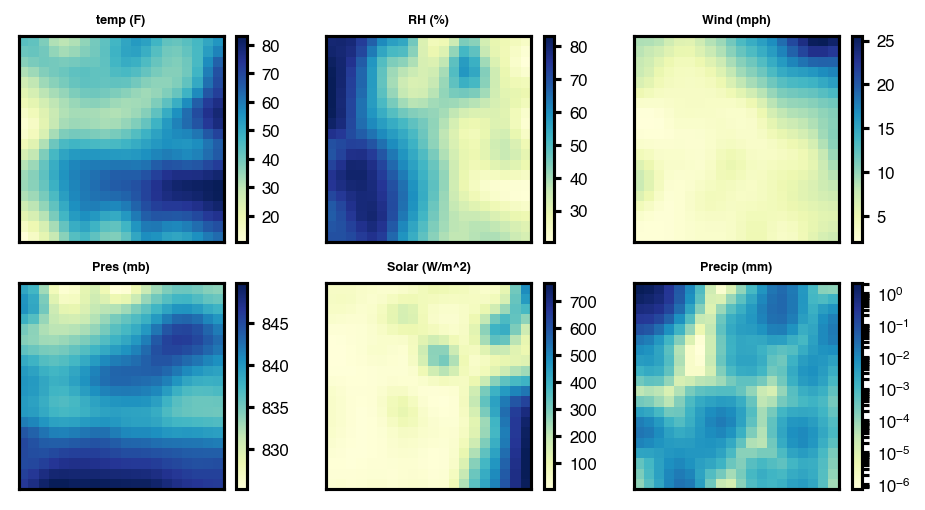

In [4]:
# choose my colorbar
my_cmap = plt.cm.get_cmap('YlGnBu')

# get the relevant SOMPY output
codebook = sm._normalizer.denormalize_by(sm.data_raw, sm.codebook.matrix)

# make the plot
cgf.cfig(1,fig_width = cgf.fig_width*1.5, fig_height = cgf.fig_height*.8*1.5)
for ind in range(0,np.size(codebook,axis=1)):
    weights = codebook[:,ind]
    
    xplot = codebook[:, ind].reshape(sm.codebook.mapsize[0],sm.codebook.mapsize[1])
    
    ax = plt.subplot(2, 3, ind+1)
    
    plt.axis([0, sm.codebook.mapsize[1], 0, sm.codebook.mapsize[0]])
    if(names[ind] in 'Precip (mm)'):
        pl = plt.pcolor(xplot, cmap = my_cmap, norm=colors.LogNorm(vmin=xplot.min(), vmax=xplot.max()))
    else:
        pl = plt.pcolor(xplot, cmap = my_cmap)
        
    plt.yticks([])
    plt.xticks([])
    cbar = plt.colorbar()
    
    cbar.ax.tick_params(labelsize=8) 
    
    plt.title(names[ind], fontsize = cgf.fig_title_size*.4)
    
plt.show()

### Plot the "hits" map
The "Hits Map" is a map of how many times a particular sample falls into a particular SOM. In our example here, what is the number of days that look like each SOM? We see from the hits map below where the most frequent SOMs/states of the atmosphere lie. So, we can go and look at the figure above and see what values the different variables take-on during this time. Looks like "cold/moist/low wind/mix of pressures/cloudy/precipitating a little" (at least that is what it looked like when I ran this!).

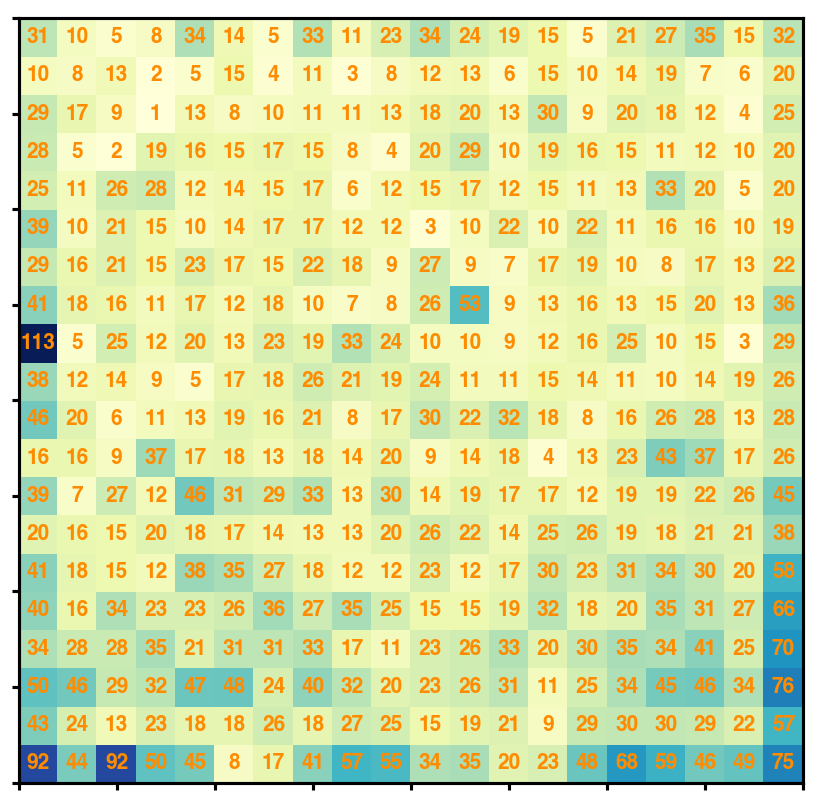

In [5]:
# this function just makes it faster to write the numbers in each of the grid boxes
def set_labels(cents, ax, labels, fontsize):
    for i, txt in enumerate(labels):
        plt.annotate(txt, (cents[i, 1] + 0.5, cents[i, 0] + 0.5), va="center", ha="center", 
            size=fontsize, color = 'darkorange', fontweight = 'bold')

# choosing my colorbar
my_cmap = plt.cm.get_cmap('YlGnBu')
        
#plotting the results using the SOMPY toolbox    
cgf.cfig(2,fig_width = cgf.fig_width*1.35, fig_height = cgf.fig_width*1.35)
ax = plt.gca()

bmu_mapping = sm._bmu[0,:]
counts = Counter(bmu_mapping)
counts = [counts.get(x, 0) for x in range(sm.codebook.mapsize[0] * sm.codebook.mapsize[1])]
xplot = np.array(counts).reshape(sm.codebook.mapsize[0],sm.codebook.mapsize[1])

msz = sm.codebook.mapsize
cents = sm.bmu_ind_to_xy(np.arange(0, msz[0] * msz[1]))

set_labels(cents, ax, counts, fontsize=10)

pl = plt.pcolor(xplot, cmap=my_cmap)

plt.axis([0, sm.codebook.mapsize[1], 0, sm.codebook.mapsize[0]])
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.show()